# Transparent Insight: Exploring XAI with ResNets for Brain and Kidney Imaging Analysis



##### Tuncer Sivri
##### Sare Naz Bayraktutan

In this project, we propose to explore eXplainable Artificial Intelligence (XAI) techniques using ResNet models on brain and kidney datasets. XAI methods such as SHAP (SHapley Additive exPlanations), LIME (Local Interpretable Model-agnostic Explanations), and GradCAM (Gradient-weighted Class Activation Mapping) will be employed to interpret and understand the model's decisions. The goal is to gain insights into how models operate on medical imaging datasets and to compare the interpretability and performance of different XAI techniques.

## Table of Content

[Problem](#problem)   
[Data Understanding](#data_understanding)
[Data Preparation](#data_preparation)
[Modeling and Evaluation](#modeling_and_evaluation)   
[SHAP Part](#SHAP_part)   
[LIME Part](#LIME_part)   
[GRAD-CAM Part](#GRAD-CAM_part)   
[Further Analysis](#further_analysis)   
[References](#references)   


In [ ]:
# Required installs

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.8 MB/s eta 0:00:00


In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=69f0a941c793f888b9452ef8bd79a9ca426fc49eb9e2baaaedde08c10bcdd953
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.preprocessing.image import save_img
import os
from PIL import Image
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras
import warnings
warnings.filterwarnings(action="ignore")
%matplotlib inline
from tqdm.keras import TqdmCallback
from tqdm.auto import tqdm  # For progress bar
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import shap
from tensorflow.keras.applications.resnet50 import preprocess_input
import random
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionResNetV2
import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Problem <a class="anchor" id="problem"></a>


The problem is trying to understand which parts of the images are influencing the model's predictions the most.

#### Data Understanding <a class="anchor" id="data_understanding"></a>

In [ ]:

Cyst_dir = ['/content/drive/MyDrive/kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst']

Normal_dirs = ['/content/drive/MyDrive/kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal']

Stone_dirs = ['/content/drive/MyDrive/kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone']

Tumor_dirs = ['/content/drive/MyDrive/kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor']

filepaths = []
labels = []
dict_lists = [Cyst_dir, Normal_dirs,Stone_dirs, Tumor_dirs]
class_labels = ['Cyst', 'Normal', 'Stone', 'Tumor']

In [ ]:
for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
KIDNEY_data = pd.concat([Fseries, Lseries], axis=1)
KIDNEY_df = pd.DataFrame(KIDNEY_data)
print(KIDNEY_df.head())
print(KIDNEY_df["labels"].value_counts())

                                           filepaths labels
0  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...   Cyst
1  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...   Cyst
2  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...   Cyst
3  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...   Cyst
4  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...   Cyst
labels
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64


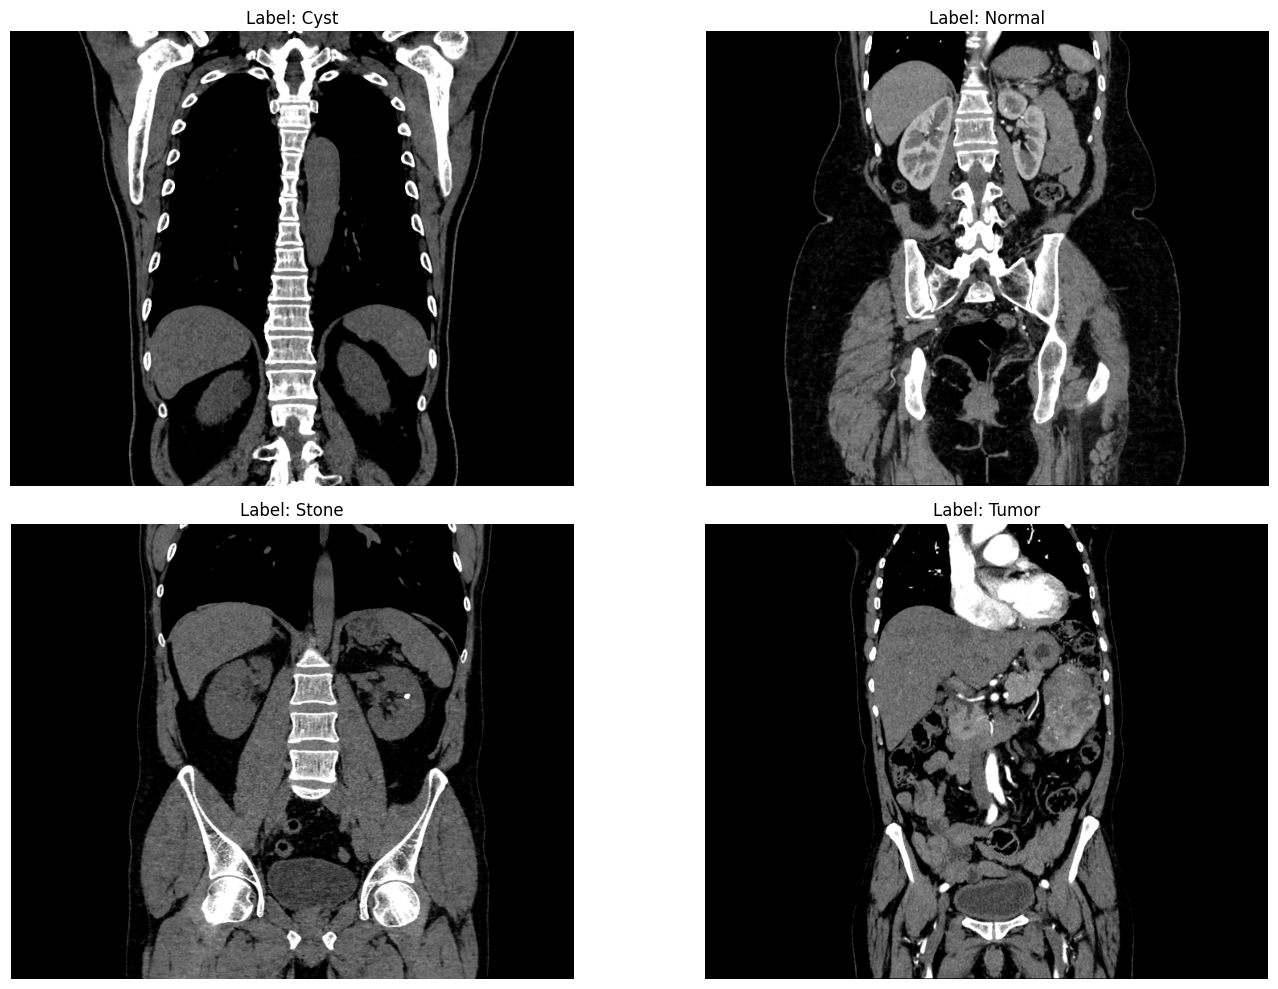

In [ ]:
# Set the size of the plot
plt.figure(figsize=(15, 10))

for i, label in enumerate(class_labels):
    # Find the first occurrence of the label in the DataFrame
    sample_row = KIDNEY_df[KIDNEY_df['labels'] == label].iloc[0]

    # Load the image
    image_path = sample_row['filepaths']
    image = Image.open(image_path)

    # Display the image with its label
    plt.subplot(2, 2, i+1)  # Arrange plots in 2x2 grid
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')  # Turn off the axis

plt.tight_layout()
plt.show()

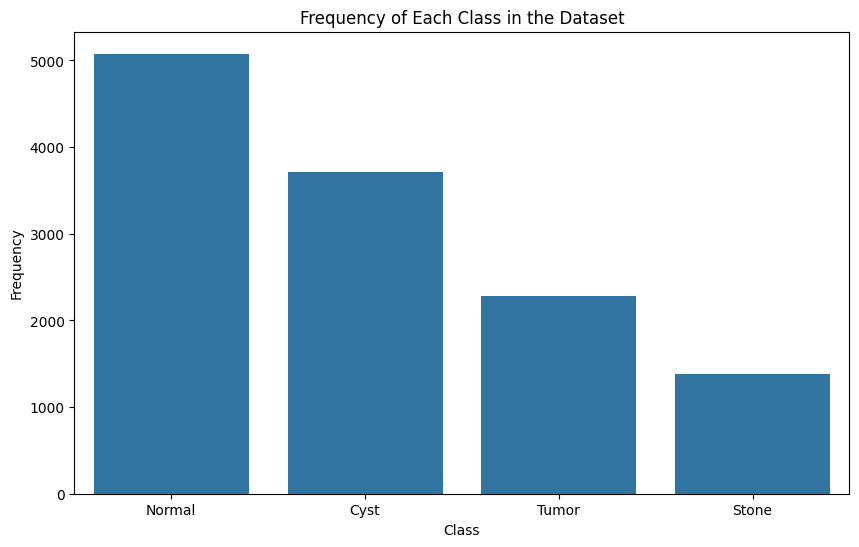

In [ ]:
# Get the frequency of each label
label_counts = KIDNEY_df['labels'].value_counts()

# Plot the frequency table
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Frequency of Each Class in the Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


In [ ]:
KIDNEY_df.shape

(12446, 2)

In [ ]:
def analyze_image_properties(image_paths, label):
    sizes = []
    modes = []

    for path in image_paths:
        with Image.open(path) as img:
            sizes.append(img.size)  # Get image size (width, height)
            modes.append(img.mode)  # Get image color mode (e.g., RGB, grayscale)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.hist([s[0] for s in sizes], bins=30, alpha=0.5, label='Width')
    plt.hist([s[1] for s in sizes], bins=30, alpha=0.5, label='Height')
    plt.title(f'Image Sizes Distribution for {label} Class')
    plt.xlabel('Pixels')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    print(f"Color Modes for {label} Class: {set(modes)}")


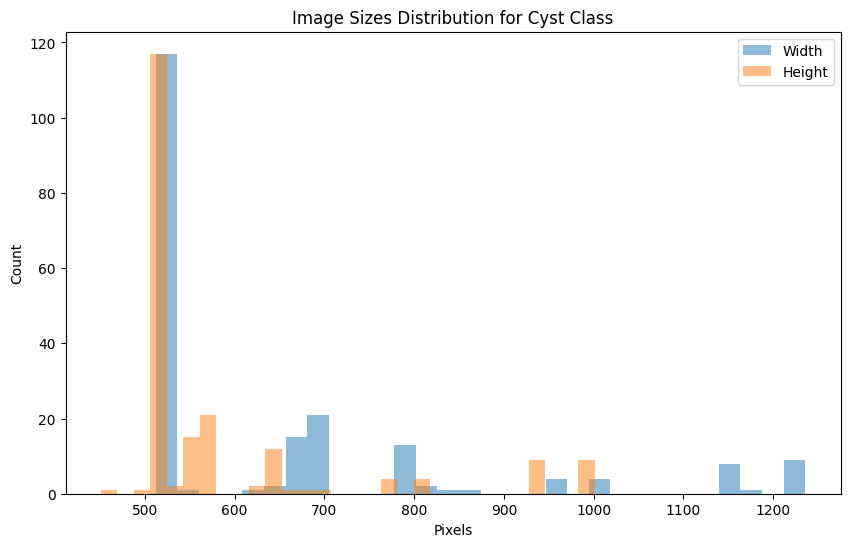

Color Modes for Cyst Class: {'RGB'}


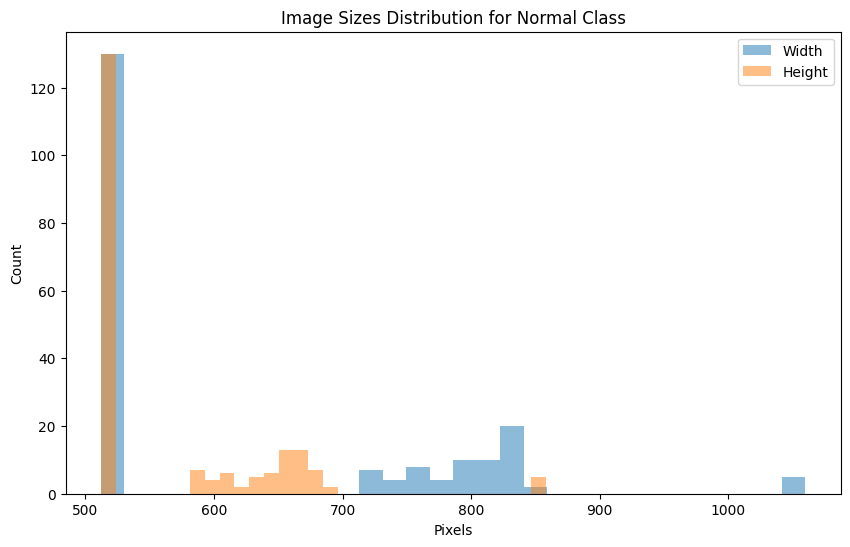

Color Modes for Normal Class: {'RGB'}


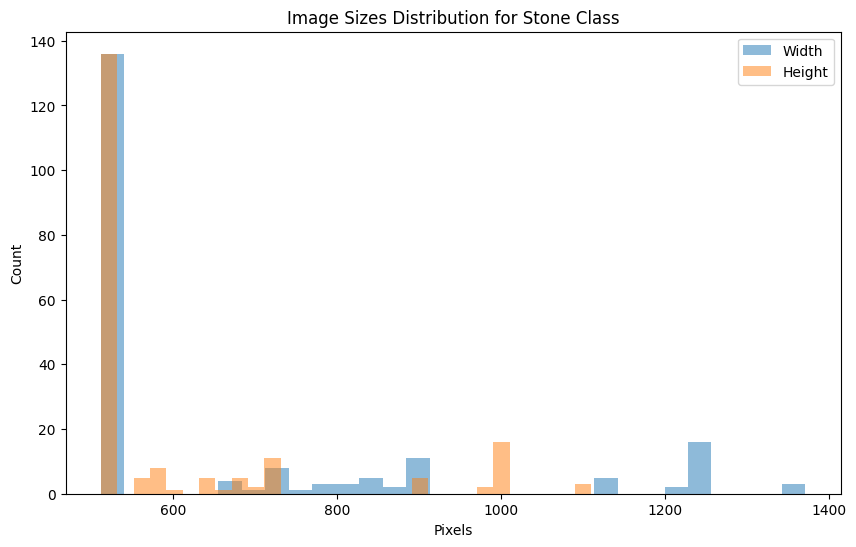

Color Modes for Stone Class: {'RGB'}


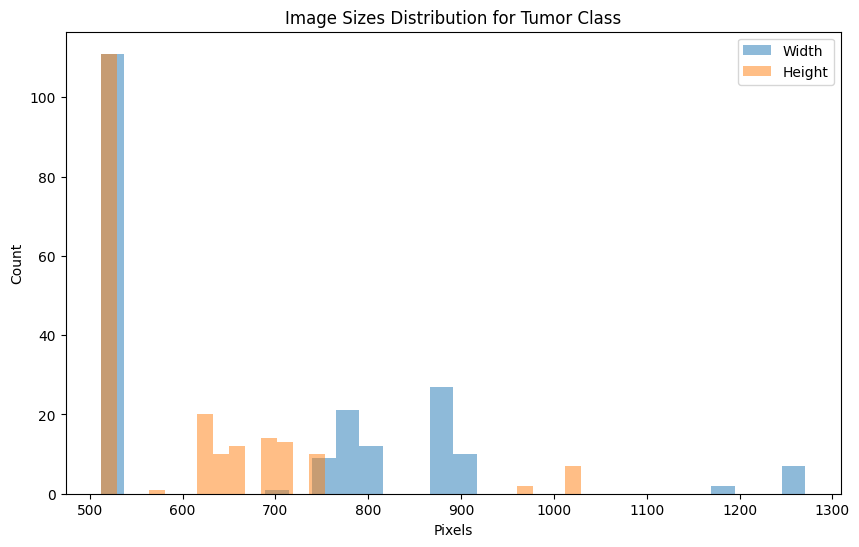

Color Modes for Tumor Class: {'RGB'}


In [ ]:
# Sample a few image paths from each class
sample_size = 200  # Number of images to sample from each class
sampled_paths = {label: KIDNEY_df[KIDNEY_df['labels'] == label].sample(sample_size)['filepaths'].tolist() for label in class_labels}

# Analyze image properties for each class
for label, paths in sampled_paths.items():
    analyze_image_properties(paths, label)

Consistency of Image Sizes: The majority of images within each class have a similar width and height, which is beneficial for analysis. A common width is 512 pixels, which seems to be the mode of the distribution for each class. However, there is some variation in the heights, particularly in the Tumor class, which shows a wider range of heights.

Size Variation: There is a variation in image sizes, particularly noticeable in the Tumor class. This variation suggests that resizing images to a consistent dimension, such as 256x256 pixels, would be a necessary preprocessing step before feeding them into a machine learning model.

Color Mode: All classes are confirmed to be in 'RGB' mode, which means that each image has three color channels (Red, Green, and Blue). This consistency in color mode means that no additional preprocessing is required to standardize the color channels across the dataset.

#### Data Preparation <a class="anchor" id="data_preparation"></a>

In [ ]:
# Define the base directory for processed images
processed_base_dir = '/content/drive/MyDrive/kidney/processed_images'

# Create the directories for processed images, one for each label
for label in class_labels:
    os.makedirs(os.path.join(processed_base_dir, label), exist_ok=True)

# Function to process and save the image
def process_and_save_image(file_path, label):
    # Define the save path
    save_dir = os.path.join(processed_base_dir, label)
    file_name = os.path.basename(file_path)
    save_path = os.path.join(save_dir, file_name)

    # Process the image
    with Image.open(file_path) as img:
        resized_img = img.resize((256, 256))
        resized_img.save(save_path)

    return save_path

# Process images and save them
processed_filepaths = []
for index, row in tqdm(KIDNEY_df.iterrows(), total=KIDNEY_df.shape[0]):
    new_path = process_and_save_image(row['filepaths'], row['labels'])
    processed_filepaths.append(new_path)

# Add the new file paths to the DataFrame
KIDNEY_df['processed_filepaths'] = processed_filepaths

# Save the DataFrame to a CSV file
processed_df_path = '/content/drive/MyDrive/kidney/processed_kidney_df.csv'
KIDNEY_df.to_csv(processed_df_path, index=False)

  0%|          | 0/12446 [00:00<?, ?it/s]

In [ ]:
#usttekini bir kez calistirdiysan artik sadece bunu calistirman yeterli
processed_filepaths = '/content/drive/MyDrive/kidney/processed_kidney_df.csv'
KIDNEY_df['processed_filepaths'] = processed_filepaths


In [ ]:
KIDNEY_df

filepaths labels  \
0      /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...   Cyst   
1      /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...   Cyst   
2      /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...   Cyst   
3      /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...   Cyst   
4      /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...   Cyst   
...                                                  ...    ...   
12441  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...  Tumor   
12442  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...  Tumor   
12443  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...  Tumor   
12444  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...  Tumor   
12445  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...  Tumor   

                                     processed_filepaths  
0      /content/drive/MyDrive/kidney/processed_kidney...  
1      /content/drive/MyDrive/kidney/processed_kidney...  
2      /content/drive/MyDrive/kidney/processed_kidney...  
3      /content/drive/MyDrive/kidney/processed_kidney...  
4      /content/drive/MyDrive/kidney/processed_kidney...  
...                                                  ...  
12441  /content/drive/MyDrive/kidney/processed_kidney...  
12442  /content/drive/MyDrive/kidney/processed_kidney...  
12443  /content/drive/MyDrive/kidney/processed_kidney...  
12444  /content/drive/MyDrive/kidney/processed_kidney...  
12445  /content/drive/MyDrive/kidney/processed_kidney...  

[12446 rows x 3 columns]

In [ ]:

sample_sizes = {'Normal': 395, 'Cyst': 827, 'Tumor': 826, 'Stone': 822}
sampled_data = pd.concat([KIDNEY_df[KIDNEY_df['labels'] == label].sample(n=size, random_state=42)
                          for label, size in sample_sizes.items()])

In [ ]:
sampled_data

filepaths  labels  \
6004  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...  Normal   
8322  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...  Normal   
3742  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...  Normal   
6939  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...  Normal   
8059  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...  Normal   
...                                                 ...     ...   
9518  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...   Stone   
9000  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...   Stone   
8948  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...   Stone   
8918  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...   Stone   
9794  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...   Stone   

                                    processed_filepaths  
6004  /content/drive/MyDrive/kidney/processed_kidney...  
8322  /content/drive/MyDrive/kidney/processed_kidney...  
3742  /content/drive/MyDrive/kidney/processed_kidney...  
6939  /content/drive/MyDrive/kidney/processed_kidney...  
8059  /content/drive/MyDrive/kidney/processed_kidney...  
...                                                 ...  
9518  /content/drive/MyDrive/kidney/processed_kidney...  
9000  /content/drive/MyDrive/kidney/processed_kidney...  
8948  /content/drive/MyDrive/kidney/processed_kidney...  
8918  /content/drive/MyDrive/kidney/processed_kidney...  
9794  /content/drive/MyDrive/kidney/processed_kidney...  

[2870 rows x 3 columns]

In [ ]:
# Assuming 'filepaths' and 'labels' are the columns in KIDNEY_df that contain the image file paths and their corresponding labels
X = sampled_data['filepaths']
y = sampled_data['labels']

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split train data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train) # 0.25 x 0.8 = 0.2


In [ ]:
image_size = (256, 256)
num_classes = sampled_data['labels'].nunique()

In [ ]:
# Create a data generator for loading images
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe=pd.concat([X_train, y_train], axis=1),
                                                    x_col='filepaths',
                                                    y_col='labels',
                                                    target_size=(256, 256),
                                                    class_mode='categorical',
                                                    batch_size=32)
val_generator = val_datagen.flow_from_dataframe(dataframe=pd.concat([X_val, y_val], axis=1),
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=(256, 256),
                                                class_mode='categorical',
                                                batch_size=32)
test_generator = test_datagen.flow_from_dataframe(dataframe=pd.concat([X_test, y_test], axis=1),
                                                  x_col='filepaths',
                                                  y_col='labels',
                                                  target_size=(256, 256),
                                                  class_mode='categorical',
                                                  batch_size=32, shuffle=False)


Found 1722 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.


### Modeling and Evaluation <a class="anchor" id="modeling_and_evaluation"></a>

##### Creating and training the ResNet model

In [ ]:
# Create the model
model = Sequential([
    ResNet50(include_top=False, pooling='avg', weights='imagenet'),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(num_classes, activation='softmax')  # Use the dynamic number of classes
])


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model with Early Stopping
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {accuracy*100:.2f}%")

18/18 [==============================] - 5s 242ms/step - loss: 0.1854 - accuracy: 0.9390
Test accuracy: 93.90%


In [ ]:
# Generate predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys(), output_dict=True)

print("Classification Report:")
print(report)

18/18 [==============================] - 6s 301ms/step
Classification Report:
{'Cyst': {'precision': 1.0, 'recall': 0.9397590361445783, 'f1-score': 0.9689440993788819, 'support': 166}, 'Normal': {'precision': 0.9285714285714286, 'recall': 0.8227848101265823, 'f1-score': 0.87248322147651, 'support': 79}, 'Stone': {'precision': 0.8497409326424871, 'recall': 1.0, 'f1-score': 0.9187675070028012, 'support': 164}, 'Tumor': {'precision': 0.9935483870967742, 'recall': 0.9333333333333333, 'f1-score': 0.9625000000000001, 'support': 165}, 'accuracy': 0.9390243902439024, 'macro avg': {'precision': 0.9429651870776725, 'recall': 0.9239692949011236, 'f1-score': 0.9306737069645483, 'support': 574}, 'weighted avg': {'precision': 0.9453835186088476, 'recall': 0.9390243902439024, 'f1-score': 0.9394795577386728, 'support': 574}}


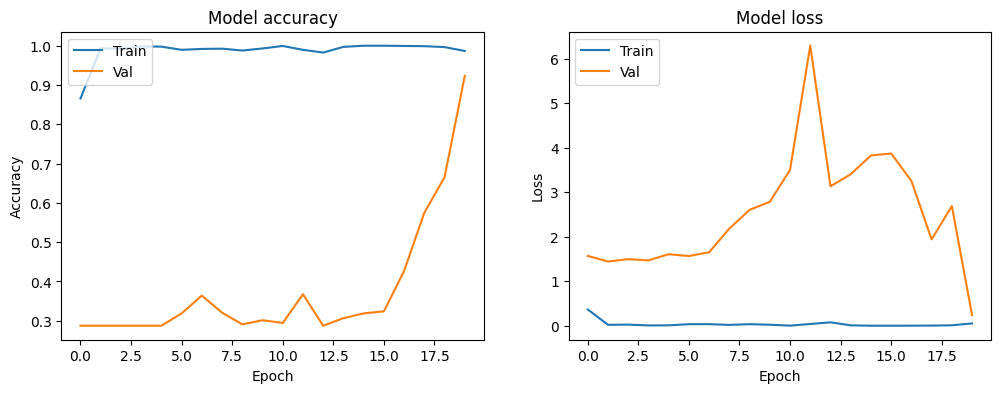

In [ ]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

In [ ]:
model.save("/content/drive/MyDrive/kidney/resnet_model_kidney.h5")

##### Creating and training the InceptionResNetV2 model

In [ ]:
model2 = Sequential([
    InceptionResNetV2(include_top=False, pooling='avg', weights='imagenet'),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(num_classes, activation='softmax')  # Use the dynamic number of classes
])

219055592/219055592 [==============================] - 2s 0us/step


In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model with Early Stopping
history2 = model2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
# Evaluate the model
loss2, accuracy2 = model2.evaluate(test_generator)
print(f"Test accuracy: {accuracy2*100:.2f}%")

18/18 [==============================] - 156s 9s/step - loss: 0.0165 - accuracy: 0.9930
Test accuracy: 99.30%


In [ ]:
# Generate predictions
predictions2 = model2.predict(test_generator)
predicted_classes2 = np.argmax(predictions2, axis=1)
true_classes2 = test_generator.classes

# Generate a classification report
report2 = classification_report(true_classes2, predicted_classes2, target_names=test_generator.class_indices.keys(), output_dict=True)

print("Classification Report:")
print(report2)

18/18 [==============================] - 8s 262ms/step
Classification Report:
{'Cyst': {'precision': 1.0, 'recall': 0.9939759036144579, 'f1-score': 0.9969788519637462, 'support': 166}, 'Normal': {'precision': 1.0, 'recall': 0.9620253164556962, 'f1-score': 0.9806451612903226, 'support': 79}, 'Stone': {'precision': 0.9939393939393939, 'recall': 1.0, 'f1-score': 0.9969604863221885, 'support': 164}, 'Tumor': {'precision': 0.9821428571428571, 'recall': 1.0, 'f1-score': 0.9909909909909909, 'support': 165}, 'accuracy': 0.9930313588850174, 'macro avg': {'precision': 0.9940205627705628, 'recall': 0.9890003050175386, 'f1-score': 0.9913938726418121, 'support': 574}, 'weighted avg': {'precision': 0.9931352474470941, 'recall': 0.9930313588850174, 'f1-score': 0.9930043387426304, 'support': 574}}


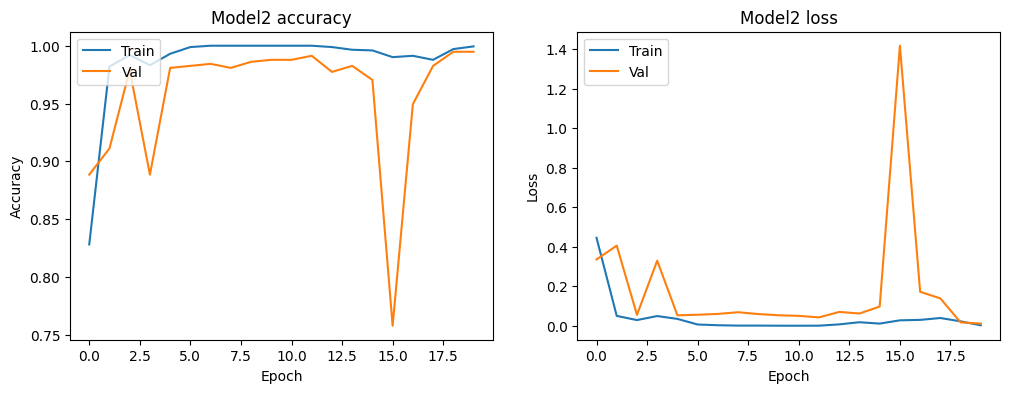

In [ ]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

In [ ]:
model2.save("/content/drive/MyDrive/kidney/inc_resnet_model_kidney.h5")

In [ ]:
# Load the model back from the file
model = load_model("/content/drive/MyDrive/kidney/resnet_model_kidney.h5")
print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
# Assuming 'base_dir' is the base directory containing the folders of images
base_dir = r"/content/drive/MyDrive/kidney/processed_images"
class_labels = os.listdir(base_dir)  # Assuming each subfolder represents a class

### SHAP Part <a class="anchor" id="SHAP_part"></a>

In [ ]:
def load_and_preprocess_image(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((256, 256))
    img = np.array(img, dtype=np.uint8)
    if img.ndim == 2:
        img = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB
    img = preprocess_input(img)
    return img

In [ ]:
def f(x):
    return model.predict(x)

In [ ]:
def f2(x):
    return model2.predict(x)

In [ ]:
# Load and preprocess images, selecting 5 randomly from each folder
images = []
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))  # Select 5 or fewer images
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        images.append((img_path, load_and_preprocess_image(img_path)))

##### Shap application with ResNet model

In [ ]:
# Store SHAP values grouped by folder
shap_results_by_folder = {}

# Load and preprocess images, selecting 5 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))  # Select 5 or fewer images
    shap_values_list = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        target_img = load_and_preprocess_image(img_path)
        target_img = np.expand_dims(target_img, axis=0)  # Ensure there is a batch dimension

        # Create the masker using the shape of the target image, dropping the batch dimension
        masker = shap.maskers.Image("inpaint_telea", target_img.shape[1:])

        # Define the explainer with the target as model input
        explainer = shap.Explainer(f, masker)

        # Explain the model's predictions using SHAP
        try:
            shap_values = explainer(target_img, max_evals=500)  # Set max_evals to limit computation
            shap_values_list.append(shap_values)
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    shap_results_by_folder[label] = shap_values_list

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


PartitionExplainer explainer: 2it [00:37, 37.81s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


PartitionExplainer explainer: 2it [00:32, 32.53s/it]               


1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:25, 25.03s/it]               


1/1 [==============================] - 0s 35ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


PartitionExplainer explainer: 2it [00:36, 36.84s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


PartitionExplainer explainer: 2it [00:26, 26.04s/it]               


1/1 [==============================] - 0s 35ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:17, 17.69s/it]               


1/1 [==============================] - 0s 29ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


PartitionExplainer explainer: 2it [00:34, 34.59s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


PartitionExplainer explainer: 2it [00:32, 32.44s/it]               


1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


PartitionExplainer explainer: 2it [00:18, 18.65s/it]               


1/1 [==============================] - 0s 38ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


PartitionExplainer explainer: 2it [00:22, 22.05s/it]               


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


PartitionExplainer explainer: 2it [00:33, 33.99s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


PartitionExplainer explainer: 2it [00:36, 36.49s/it]               


1/1 [==============================] - 0s 31ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


PartitionExplainer explainer: 2it [00:22, 22.03s/it]               


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


PartitionExplainer explainer: 2it [00:25, 25.58s/it]               


1/1 [==============================] - 0s 47ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:21, 21.55s/it]               


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


PartitionExplainer explainer: 2it [00:21, 21.66s/it]               


1/1 [==============================] - 0s 32ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


PartitionExplainer explainer: 2it [00:21, 21.33s/it]               


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


PartitionExplainer explainer: 2it [00:26, 26.31s/it]               


1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


PartitionExplainer explainer: 2it [00:29, 29.97s/it]               


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


PartitionExplainer explainer: 2it [00:34, 35.00s/it]               


1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


PartitionExplainer explainer: 2it [00:26, 26.50s/it]               


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


PartitionExplainer explainer: 2it [00:14, 15.00s/it]               


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


PartitionExplainer explainer: 2it [00:26, 26.04s/it]               


1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


PartitionExplainer explainer: 2it [00:15, 15.76s/it]               


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


PartitionExplainer explainer: 2it [00:21, 21.94s/it]               


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:19, 19.94s/it]               


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


PartitionExplainer explainer: 2it [00:25, 25.12s/it]               


1/1 [==============================] - 0s 31ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


PartitionExplainer explainer: 2it [00:32, 32.59s/it]               


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


PartitionExplainer explainer: 2it [00:23, 23.40s/it]               


1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


PartitionExplainer explainer: 2it [00:16, 16.37s/it]               


1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


PartitionExplainer explainer: 2it [00:19, 19.06s/it]               


1/1 [==============================] - 0s 51ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


PartitionExplainer explainer: 2it [00:22, 22.69s/it]               


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


PartitionExplainer explainer: 2it [00:18, 18.47s/it]               


1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


PartitionExplainer explainer: 2it [00:27, 27.08s/it]               


1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


PartitionExplainer explainer: 2it [00:15, 15.75s/it]               


1/1 [==============================] - 0s 28ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


PartitionExplainer explainer: 2it [00:29, 29.04s/it]               


1/1 [==============================] - 0s 27ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


PartitionExplainer explainer: 2it [00:31, 31.83s/it]               


1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


PartitionExplainer explainer: 2it [00:30, 30.33s/it]               


1/1 [==============================] - 0s 36ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step


PartitionExplainer explainer: 2it [00:36, 36.70s/it]               


1/1 [==============================] - 0s 26ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:29, 29.35s/it]               


In [ ]:
# Display SHAP results grouped by folder
for label, shap_values_list in shap_results_by_folder.items():
    print(f"SHAP results for label: {label}")
    for shap_values in shap_values_list:
        shap.image_plot(shap_values)

Output hidden; open in https://colab.research.google.com to view.

##### Shap application with InceptionResNetV2 model

In [ ]:
# Store SHAP values grouped by folder WITH INCEPTIONRESNETV2 MODEL
shap_results_by_folder = {}

# Load and preprocess images, selecting 5 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))  # Select 5 or fewer images
    shap_values_list = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        target_img = load_and_preprocess_image(img_path)
        target_img = np.expand_dims(target_img, axis=0)  # Ensure there is a batch dimension

        # Create the masker using the shape of the target image, dropping the batch dimension
        masker = shap.maskers.Image("inpaint_telea", target_img.shape[1:])

        # Define the explainer with the target as model input
        explainer = shap.Explainer(f2, masker)

        # Explain the model's predictions using SHAP
        try:
            shap_values = explainer(target_img, max_evals=500)  # Set max_evals to limit computation
            shap_values_list.append(shap_values)
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    shap_results_by_folder[label] = shap_values_list

1/1 [==============================] - 2s 2s/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


PartitionExplainer explainer: 2it [00:39, 39.73s/it]               


1/1 [==============================] - 0s 67ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 164ms/step


PartitionExplainer explainer: 2it [00:48, 48.35s/it]               


1/1 [==============================] - 0s 175ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


PartitionExplainer explainer: 2it [00:32, 32.60s/it]               


1/1 [==============================] - 0s 46ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


PartitionExplainer explainer: 2it [00:34, 34.39s/it]               


1/1 [==============================] - 0s 45ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


PartitionExplainer explainer: 2it [00:29, 29.83s/it]               


1/1 [==============================] - 0s 50ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


PartitionExplainer explainer: 2it [00:56, 56.28s/it]               


1/1 [==============================] - 0s 131ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


PartitionExplainer explainer: 2it [00:34, 34.91s/it]               


1/1 [==============================] - 0s 67ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


PartitionExplainer explainer: 2it [00:27, 27.25s/it]               


1/1 [==============================] - 0s 44ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


PartitionExplainer explainer: 2it [00:20, 20.27s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


PartitionExplainer explainer: 2it [00:26, 26.55s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


PartitionExplainer explainer: 2it [00:28, 28.66s/it]               


1/1 [==============================] - 0s 42ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 60ms/step


PartitionExplainer explainer: 2it [00:40, 40.52s/it]               


1/1 [==============================] - 0s 48ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


PartitionExplainer explainer: 2it [00:30, 30.42s/it]               


1/1 [==============================] - 0s 46ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 66ms/step


PartitionExplainer explainer: 2it [00:40, 40.57s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


PartitionExplainer explainer: 2it [00:22, 22.05s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


PartitionExplainer explainer: 2it [00:39, 39.44s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


PartitionExplainer explainer: 2it [00:24, 24.48s/it]               


1/1 [==============================] - 0s 66ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


PartitionExplainer explainer: 2it [00:39, 39.31s/it]               


1/1 [==============================] - 0s 48ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


PartitionExplainer explainer: 2it [00:40, 40.43s/it]               


1/1 [==============================] - 0s 46ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 68ms/step


PartitionExplainer explainer: 2it [00:22, 23.00s/it]               


1/1 [==============================] - 0s 44ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


PartitionExplainer explainer: 2it [00:22, 22.80s/it]               


1/1 [==============================] - 0s 51ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


PartitionExplainer explainer: 2it [00:35, 35.84s/it]               


1/1 [==============================] - 0s 86ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


PartitionExplainer explainer: 2it [00:22, 22.68s/it]               


1/1 [==============================] - 0s 44ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 88ms/step


PartitionExplainer explainer: 2it [00:24, 24.06s/it]               


1/1 [==============================] - 0s 48ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


PartitionExplainer explainer: 2it [00:33, 33.47s/it]               


1/1 [==============================] - 0s 72ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


PartitionExplainer explainer: 2it [00:24, 24.42s/it]               


1/1 [==============================] - 0s 64ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


PartitionExplainer explainer: 2it [00:29, 29.74s/it]               


1/1 [==============================] - 0s 90ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


PartitionExplainer explainer: 2it [00:28, 28.29s/it]               


1/1 [==============================] - 0s 44ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step


PartitionExplainer explainer: 2it [00:34, 34.14s/it]               


1/1 [==============================] - 0s 44ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


PartitionExplainer explainer: 2it [00:28, 28.79s/it]               


1/1 [==============================] - 0s 48ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


PartitionExplainer explainer: 2it [00:40, 40.11s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


PartitionExplainer explainer: 2it [00:32, 32.52s/it]               


1/1 [==============================] - 0s 57ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


PartitionExplainer explainer: 2it [00:26, 26.38s/it]               


1/1 [==============================] - 0s 68ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


PartitionExplainer explainer: 2it [00:41, 41.53s/it]               


1/1 [==============================] - 0s 65ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


PartitionExplainer explainer: 2it [00:39, 39.77s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


PartitionExplainer explainer: 2it [00:32, 32.81s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


PartitionExplainer explainer: 2it [00:37, 37.86s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


PartitionExplainer explainer: 2it [00:25, 25.05s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


PartitionExplainer explainer: 2it [00:29, 29.66s/it]               


1/1 [==============================] - 0s 61ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


PartitionExplainer explainer: 2it [00:31, 31.35s/it]               


In [ ]:
# Display SHAP results grouped by folder
for label, shap_values_list in shap_results_by_folder.items():
    print(f"SHAP results for label: {label}")
    for shap_values in shap_values_list:
        shap.image_plot(shap_values)

Output hidden; open in https://colab.research.google.com to view.

### LIME Part<a class="anchor" id="LIME_part"></a>

In [ ]:
# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))  # InceptionV3 expects 299x299 input
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [ ]:
def model_predict(img_batch):
    return model.predict(img_batch)

In [ ]:
def model_predict2(img_batch):
    return model2.predict(img_batch)

##### Lime application with ResNet model

In [ ]:

# Create a LIME explainer object
explainer = lime_image.LimeImageExplainer()

# Store explanations grouped by folder
explanations_by_folder = {}

# Load and preprocess images, selecting 5 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))  # Select 105 or fewer images
    explanations = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        img = load_and_preprocess_image(img_path)

        # Explain a prediction from the model
        try:
            explanation = explainer.explain_instance(img[0].astype('double'), model_predict, top_labels=5, hide_color=0, num_samples=1000)

            # Get image and mask for the top prediction
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                        positive_only=False, num_features=10, hide_rest=False)
            explanations.append((temp, mask))
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    explanations_by_folder[label] = explanations

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 58ms/step


In [ ]:
# Display explanations grouped by folder
for label, explanations in explanations_by_folder.items():
    print(f"Explanations for label: {label}")
    for temp, mask in explanations:
        plt.figure(figsize=(8, 8))
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

##### Lime application with InceptionResNetV2 model

In [ ]:

# Create a LIME explainer object with inceptionresnetv2
explainer = lime_image.LimeImageExplainer()

# Store explanations grouped by folder
explanations_by_folder = {}

# Load and preprocess images, selecting 5 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))  # Select 105 or fewer images
    explanations = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        img = load_and_preprocess_image(img_path)

        # Explain a prediction from the model
        try:
            explanation = explainer.explain_instance(img[0].astype('double'), model_predict2, top_labels=5, hide_color=0, num_samples=1000)

            # Get image and mask for the top prediction
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                        positive_only=False, num_features=10, hide_rest=False)
            explanations.append((temp, mask))
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    explanations_by_folder[label] = explanations

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 70ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 60ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 94ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 69ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 81ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 85ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 66ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 70ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


In [ ]:
# Display explanations grouped by folder
for label, explanations in explanations_by_folder.items():
    print(f"Explanations for label: {label}")
    for temp, mask in explanations:
        plt.figure(figsize=(8, 8))
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

### GRAD-CAM Part <a class="anchor" id="GRAD-CAM_part"></a>

In [ ]:
# Assuming you have a 'model_predict' function and 'preprocess_input' ready
def load_and_preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')  # Ensure images are RGB
    img = img.resize((224, 224))  # Adjust size to fit model expected input
    img = np.array(img, dtype=np.float32)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # Apply model-specific preprocessing
    return img

In [ ]:
def model_predict(image_array):
    # Convert image array to a suitable format your model expects, if not already
    # Return prediction probabilities
    return model.predict(image_array)

In [ ]:
def model_predict2(image_array):
    # Convert image array to a suitable format your model expects, if not already
    # Return prediction probabilities
    return model2.predict(image_array)

##### Grad-Cam application with ResNet model

In [ ]:
# Create a Grad-Cam explainer object
explainer = grad_image.gradCAM()

# Store explanations grouped by folder
explanations_by_folder = {}

# Load and preprocess images, selecting up to 10 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))
    explanations = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        img = load_and_preprocess_image(img_path)

        # Explain the model prediction
        try:
            explanation = explainer.explain_instance(img[0].astype('double'), model_predict, top_labels=5, hide_color=0, num_samples=1000)
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                        positive_only=False, num_features=10, hide_rest=False)
            explanations.append((temp, mask))
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    explanations_by_folder[label] = explanations

# Optionally, visualize the explanations
for label, explanation_data in explanations_by_folder.items():
    print(f"Label: {label}")
    for i, (temp, mask) in enumerate(explanation_data):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(temp)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='RdBu')
        plt.title('Explanation Mask')
        plt.axis('off')
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

##### Grad-Cam application with InceptionResNetV2 model

In [ ]:
# Create a Grad-Cam explainer object
explainer = grad_image.gradCAM()

# Store explanations grouped by folder
explanations_by_folder = {}

# Load and preprocess images, selecting up to 10 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))
    explanations = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        img = load_and_preprocess_image(img_path)

        # Explain the model prediction
        try:
            explanation = explainer.explain_instance(img[0].astype('double'), model_predict2, top_labels=5, hide_color=0, num_samples=1000)
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                        positive_only=False, num_features=10, hide_rest=False)
            explanations.append((temp, mask))
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    explanations_by_folder[label] = explanations

# Optionally, visualize the explanations
for label, explanation_data in explanations_by_folder.items():
    print(f"Label: {label}")
    for i, (temp, mask) in enumerate(explanation_data):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(temp)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='RdBu')
        plt.title('Explanation Mask')
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Further Analysis <a class="anchor" id="further_analysis"></a>
#### Cropping the images throughout their edges and training the models with them.

In [ ]:
# Sample sizes
sample_sizes = {'Normal': 400, 'Cyst': 800, 'Tumor': 800, 'Stone': 800}
# Define your input and output directories
input_directory = '/content/drive/MyDrive/kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
output_directory = '/content/drive/MyDrive/kidney/cropped_processed_images'

In [ ]:
def sample_data(input_dir, sample_sizes):
    all_files = []
    for category, size in sample_sizes.items():
        cat_path = os.path.join(input_dir, category)
        files = os.listdir(cat_path)
        sampled_files = np.random.choice(files, size, replace=False)
        for file in sampled_files:
            all_files.append((category, os.path.join(cat_path, file)))
    return all_files

sampled_files = sample_data(input_directory, sample_sizes)

In [ ]:
# Create a DataFrame to use the existing sampling method
data = {'category': [f[0] for f in sampled_files], 'filepath': [f[1] for f in sampled_files]}
KIDNEY_df = pd.DataFrame(data)

sampled_data = pd.concat([KIDNEY_df[KIDNEY_df['category'] == label].sample(n=size, random_state=42)
                          for label, size in sample_sizes.items()])

In [ ]:
sampled_data

category                                           filepath
209    Normal  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...
280    Normal  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...
33     Normal  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...
210    Normal  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...
93     Normal  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...
...       ...                                                ...
2071    Stone  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...
2106    Stone  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...
2270    Stone  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...
2435    Stone  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...
2102    Stone  /content/drive/MyDrive/kidney/CT-KIDNEY-DATASE...

[2800 rows x 2 columns]

In [ ]:
def crop_largest_contour(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    _, thresholded = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_image = image_rgb[y:y+h, x:x+w]
    return cropped_image

In [ ]:
def process_images(data_df, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for _, row in tqdm(data_df.iterrows(), total=data_df.shape[0], desc="Processing images"):
        category = row['category']
        input_path = row['filepath']
        output_path = os.path.join(output_dir, category, os.path.basename(input_path))
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cropped_image = crop_largest_contour(input_path)
        resized_image = cv2.resize(cropped_image, (256, 256))
        cv2.imwrite(output_path, cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))

process_images(sampled_data, output_directory)


Processing images:   0%|          | 0/2800 [00:00<?, ?it/s]

In [ ]:
def load_data(directory):
    images = []
    labels = []
    label_dict = {'Normal': 0, 'Cyst': 1, 'Tumor': 2, 'Stone': 3}

    for label, idx in label_dict.items():
        path = os.path.join(directory, label)
        files = os.listdir(path)
        for file in tqdm(files, desc=f"Loading {label}"):
            img_path = os.path.join(path, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (256, 256))
            images.append(img)
            labels.append(idx)

    images = np.array(images)
    labels = to_categorical(labels, num_classes=len(label_dict))
    return images, labels

In [ ]:
# Define your input directory
input_directory = '/content/drive/MyDrive/kidney/cropped_processed_images'
images, labels = load_data(input_directory)

Loading Normal:   0%|          | 0/1232 [00:00<?, ?it/s]

Loading Cyst:   0%|          | 0/1470 [00:00<?, ?it/s]

Loading Tumor:   0%|          | 0/1120 [00:00<?, ?it/s]

Loading Stone:   0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
# First, split into a temporary training and a final test set
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Then split the temporary training set into the actual training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [ ]:
def create_model():

    model = Sequential([
      InceptionResNetV2(include_top=False, pooling='avg', weights='imagenet'),
      Flatten(),
      Dense(1024, activation='relu'),
      Dense(4, activation='softmax')  # Assuming 4 classes as per your dataset
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

219055592/219055592 [==============================] - 4s 0us/step


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=TqdmCallback(verbose=1))

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
87/87 [==============================] - 131s 478ms/step - loss: 0.3987 - accuracy: 0.8582 - val_loss: 24.4727 - val_accuracy: 0.2973
Epoch 2/10
87/87 [==============================] - 27s 309ms/step - loss: 0.0972 - accuracy: 0.9646 - val_loss: 2.3953 - val_accuracy: 0.7178
Epoch 3/10
87/87 [==============================] - 27s 312ms/step - loss: 0.0545 - accuracy: 0.9830 - val_loss: 0.0788 - val_accuracy: 0.9762
Epoch 4/10
87/87 [==============================] - 27s 309ms/step - loss: 0.0196 - accuracy: 0.9939 - val_loss: 1.9756 - val_accuracy: 0.7373
Epoch 5/10
87/87 [==============================] - 27s 308ms/step - loss: 0.0881 - accuracy: 0.9715 - val_loss: 2.6364 - val_accuracy: 0.5470
Epoch 6/10
87/87 [==============================] - 27s 309ms/step - loss: 0.0416 - accuracy: 0.9856 - val_loss: 0.3203 - val_accuracy: 0.9373
Epoch 7/10
87/87 [==============================] - 27s 309ms/step - loss: 0.0061 - accuracy: 0.9986 - val_loss: 0.1452 - val_accuracy: 0.97

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

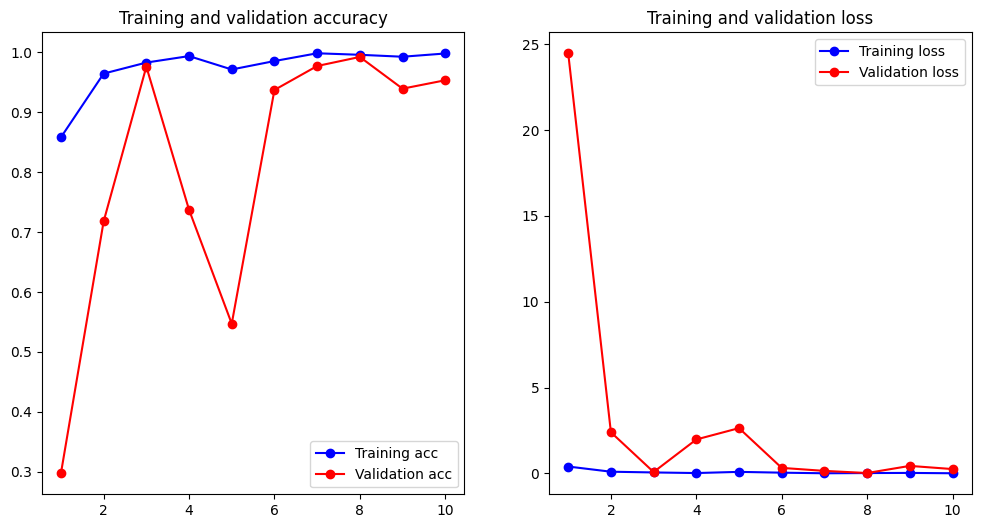

29/29 [==============================] - 6s 87ms/step
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.90      0.95       271
        no_tumor       0.97      1.00      0.98       270
meningioma_tumor       1.00      0.98      0.99       220
 pituitary_tumor       0.86      0.98      0.92       164

        accuracy                           0.96       925
       macro avg       0.96      0.97      0.96       925
    weighted avg       0.97      0.96      0.96       925



In [ ]:
label_dict = {'glioma_tumor': 0, 'no_tumor': 1, 'meningioma_tumor': 2, 'pituitary_tumor': 3}
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print(classification_report(y_true_classes, y_pred_classes, target_names=list(label_dict.keys())))

plot_history(history)
evaluate_model(model, X_test, y_test)

In [ ]:
# Assuming 'base_dir' is the base directory containing the folders of images
base_dir = r"/content/drive/MyDrive/kidney/cropped_processed_images"
class_labels = os.listdir(base_dir)  # Assuming each subfolder represents a class

#### Trying SHAP

In [ ]:
# Load and preprocess images, selecting 5 randomly from each folder
images = []
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(5, len(os.listdir(folder_path))))  # Select 5 or fewer images
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        images.append((img_path, load_and_preprocess_image(img_path)))

In [ ]:
# Store SHAP values grouped by folder
shap_results_by_folder = {}

# Load and preprocess images, selecting 5 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))  # Select 5 or fewer images
    shap_values_list = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        target_img = load_and_preprocess_image(img_path)
        target_img = np.expand_dims(target_img, axis=0)  # Ensure there is a batch dimension

        # Create the masker using the shape of the target image, dropping the batch dimension
        masker = shap.maskers.Image("inpaint_telea", target_img.shape[1:])

        # Define the explainer with the target as model input
        explainer = shap.Explainer(f, masker)

        # Explain the model's predictions using SHAP
        try:
            shap_values = explainer(target_img, max_evals=500)  # Set max_evals to limit computation
            shap_values_list.append(shap_values)
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    shap_results_by_folder[label] = shap_values_list

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


PartitionExplainer explainer: 2it [00:36, 36.17s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:25, 25.84s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:26, 26.51s/it]               


1/1 [==============================] - 0s 42ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:26, 26.89s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:31, 31.51s/it]               


1/1 [==============================] - 0s 42ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:25, 25.66s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:27, 27.60s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:26, 26.78s/it]               


1/1 [==============================] - 0s 50ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:24, 24.55s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:26, 26.70s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


PartitionExplainer explainer: 2it [00:26, 26.37s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:27, 27.79s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:27, 27.19s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:27, 27.30s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:27, 27.08s/it]               


1/1 [==============================] - 0s 44ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:26, 26.72s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:26, 26.20s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:27, 27.60s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:25, 25.58s/it]               


1/1 [==============================] - 0s 44ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:27, 27.77s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:25, 25.41s/it]               


1/1 [==============================] - 0s 45ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:30, 30.83s/it]               


1/1 [==============================] - 0s 39ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


PartitionExplainer explainer: 2it [00:28, 28.86s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:29, 29.37s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:27, 27.05s/it]               


1/1 [==============================] - 0s 42ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:27, 27.79s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


PartitionExplainer explainer: 2it [00:26, 26.51s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:25, 25.69s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:31, 31.19s/it]               


1/1 [==============================] - 0s 42ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:25, 25.35s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:30, 30.08s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:26, 26.22s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:27, 27.66s/it]               


1/1 [==============================] - 0s 40ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:26, 26.69s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:26, 26.88s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:31, 31.62s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


PartitionExplainer explainer: 2it [00:27, 27.85s/it]               


1/1 [==============================] - 0s 42ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:29, 29.33s/it]               


1/1 [==============================] - 0s 41ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:26, 26.87s/it]               


1/1 [==============================] - 0s 43ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


PartitionExplainer explainer: 2it [00:29, 29.96s/it]               


In [ ]:
# Display SHAP results grouped by folder
for label, shap_values_list in shap_results_by_folder.items():
    print(f"SHAP results for label: {label}")
    for shap_values in shap_values_list:
        shap.image_plot(shap_values)

Output hidden; open in https://colab.research.google.com to view.

#### Trying LIME


In [ ]:
# Create a LIME explainer object
explainer = lime_image.LimeImageExplainer()

# Store explanations grouped by folder
explanations_by_folder = {}

# Load and preprocess images, selecting 5 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))  # Select 10 or fewer images
    explanations = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        img = load_and_preprocess_image(img_path)

        # Explain a prediction from the model
        try:
            explanation = explainer.explain_instance(img[0].astype('double'), model_predict, top_labels=5, hide_color=0, num_samples=1000)

            # Get image and mask for the top prediction
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                        positive_only=False, num_features=10, hide_rest=False)
            explanations.append((temp, mask))
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    explanations_by_folder[label] = explanations

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


In [ ]:
# Display explanations grouped by folder
for label, explanations in explanations_by_folder.items():
    print(f"Explanations for label: {label}")
    for temp, mask in explanations:
        plt.figure(figsize=(8, 8))
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### Trying GRAD-Cam


In [ ]:
# Create a GRAD-Cam explainer object
explainer = grad_image.gradCAM()

# Store explanations grouped by folder
explanations_by_folder = {}

# Load and preprocess images, selecting up to 10 randomly from each folder
for label in class_labels:
    folder_path = os.path.join(base_dir, label)
    img_files = random.sample(os.listdir(folder_path), min(10, len(os.listdir(folder_path))))
    explanations = []
    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)
        img = load_and_preprocess_image(img_path)

        # Explain the model prediction
        try:
            explanation = explainer.explain_instance(img[0].astype('double'), model_predict, top_labels=5, hide_color=0, num_samples=1000)
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                        positive_only=False, num_features=10, hide_rest=False)
            explanations.append((temp, mask))
        except Exception as e:
            print(f"An error occurred while processing image from {label}: {e}")

    explanations_by_folder[label] = explanations

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


In [ ]:

# Optionally, visualize the explanations
for label, explanation_data in explanations_by_folder.items():
    print(f"Label: {label}")
    for i, (temp, mask) in enumerate(explanation_data):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(temp)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='RdBu')
        plt.title('Explanation Mask')
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

## References<a class="anchor" id="references"></a>


https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Image%20Multi%20Class.html
https://shap.readthedocs.io/en/latest/generated/shap.maskers.Image.html
https://www.datacamp.com/tutorial/explainable-ai-understanding-and-trusting-machine-learning-models
https://christophm.github.io/interpretable-ml-book/lime.html4
https://towardsdatascience.com/lime-explain-machine-learning-predictions-af8f18189bfe
https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb
https://www.mathworks.com/help/deeplearning/ug/gradcam-explains-why.html
https://www.analyticsvidhya.com/blog/2023/12/grad-cam-in-deep-learning/#:~:text=Grad%2DCAM%20stands%20for%20Gradient,prediction%20of%20a%20particular%20class.



**Disclaimer!** <font color='grey'>This notebook was prepared by <Sare Naz Bayraktutan and Tuncer Sivri> as a term project for the *BBM467 - Data Intensive Applications* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8).
</font>